In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import moviepy.editor as mpy
import os
from moviepy.video.io.bindings import mplfig_to_npimage
import HUXt as H
import astropy.units as u
from skimage import measure
import scipy.ndimage as ndi
%matplotlib inline

Add in CME tracker.
 - identify contiguous regions between diff of ambient and cme fields.
 - count the cmes and label as they go out. 
Add in empirical rule for density of ambient and CME.
Write Thomson scattering simulator for the 2-d solutions. 

In [2]:
# Set up HUXt1D to run a 5 day simulation of Carrington rotation 2000, and output model data every 4 timesteps (about 35min)
cr_num = 2000
lon = 0.0
model1D = H.HUXt1D(cr_num, lon=lon, simtime=5, dt_scale=4)

# Get a list of different CMEs with random launch longitudes and times
cme_list=[]
n_cme = 5
launch_lons = [10 for i in range(n_cme)]
#launch_lons = np.random.randint(0, 360, n_cme)
daysec = 86400
launch_times = [(0.25 + i*4/n_cme)*daysec for i in range(n_cme)]
               
for lon, t_launch in zip(launch_lons, launch_times):
    #print(lon, t_launch)
    cme = H.ConeCME(t_launch=t_launch, longitude=lon, width=30, v=1000, thickness=5)
    cme_list.append(cme)
    
# Run HUXt1D for these cmes, save to file 
tag = 'test'
model1D.solve(cme_list, save=False, tag=tag)

In [3]:
# Set up HUXt2D to run a simulation with the same parameters.
model2D = H.HUXt2D(cr_num, simtime=2, dt_scale=4)

# Run for the same list of cmes, save to file 
tag = 'test_rand_lon'
model2D.solve(cme_list, save=True, tag=tag) 

# Make an MP4 of the solution with CME
model2D.animate('cme', tag)

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_rand_lon_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_rand_lon_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_rand_lon_movie.mp4


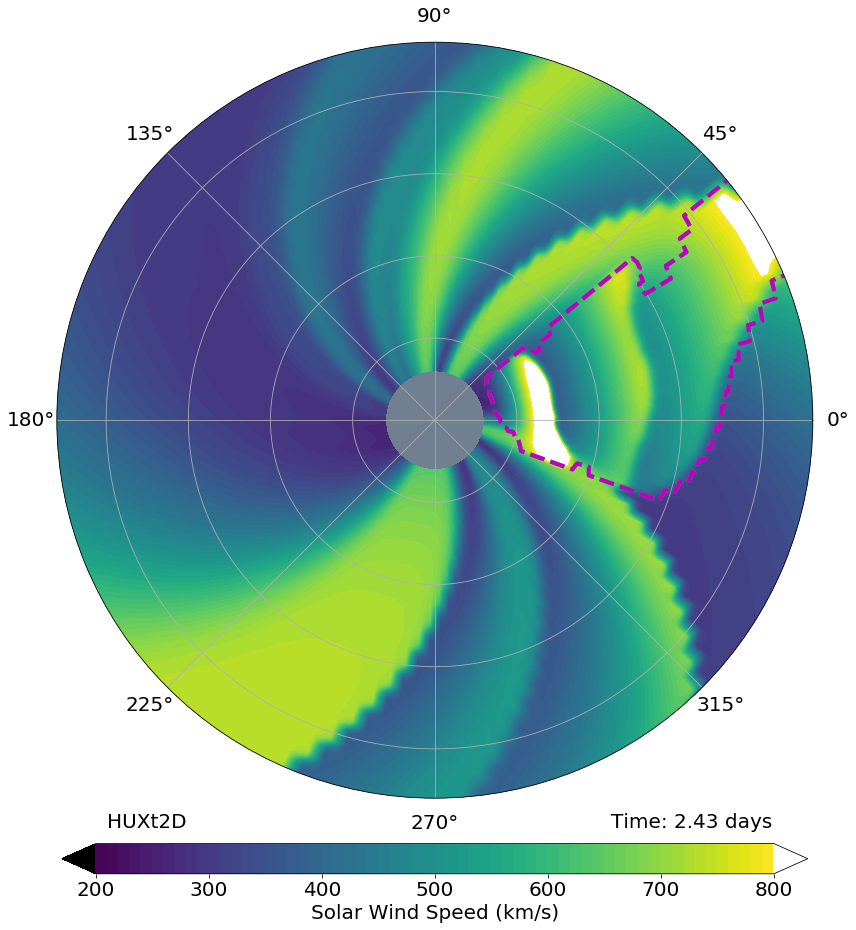

In [33]:
def plot_frame(self, t, field='cme', save=False, tag=''):
    """
    Make a contour plot on polar axis of the solar wind solution at a specific time
    :param t: Integer to index the time coordinate.
    :param field: String, either 'cme', or 'ambient', specifying which solution to plot.
    :param save: Boolean to determine if the figure is saved.
    :param tag: String to append to the filename if saving the figure.
    :return:
    """

    if field not in ['cme', 'ambient']:
        print("Error, field must be either 'cme', or 'ambient'. Default to CME")
        field = 'cme'

    if (t<0) | (t > (self.Nt_out-1)):
        print("Error, invalid time index t")

    # Get plotting data
    lon = self.lon_grid.value.copy()
    rad = self.r_grid.value.copy()
    if field == 'cme':
        v = self.v_grid_cme.value[t, :, :].copy()
    elif field == 'ambient':
        v = self.v_grid_amb.value[t, :, :].copy()


    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + self.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)
    
    # Add colorbar
    mymap = mpl.cm.viridis
    mymap.set_over([1, 1, 1])
    mymap.set_under([0, 0, 0])
    dv = 10
    levels = np.arange(200, 800+dv, dv)
    fig, ax = plt.subplots(figsize=(14, 14), subplot_kw={"projection": "polar"})
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')
    # Add on CME boundaries
    cme_colors = ['r', 'c', 'm', 'y', 'white', 'darkorange', 'deeppink']
    for j, cme in enumerate(self.cmes):
        cid = np.mod(j, len(cme_colors))
        ax.plot(cme.coords[t]['lon'], cme.coords[t]['r'], '--', color=cme_colors[cid], linewidth=4)

    ax.set_ylim(0, 230)
    ax.set_yticklabels([])
    ax.tick_params(axis='x', which='both', pad=15)
    ax.patch.set_facecolor('slategrey')
    fig.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.95)

    pos = ax.get_position()
    dw = 0.005
    dh = 0.075
    left = pos.x0 + dw
    bottom = pos.y0 - dh
    wid = pos.width - 2*dw
    cbaxes = fig.add_axes([left, bottom, wid, 0.03])
    cbar1 = fig.colorbar(cnt, cax=cbaxes, orientation='horizontal')
    cbar1.set_label("Solar Wind Speed (km/s)")
    cbar1.set_ticks(np.arange(200,900,100))

    # Add label
    label = "Time: {:3.2f} days".format(self.time_out[t].to(u.day).value)
    fig.text(0.675, 0.17, label, fontsize=20)
    label = "HUXt2D"
    fig.text(0.175, 0.17, label, fontsize=20)
    if save:
        cr_num = np.int32(self.cr_num.value)
        filename = "HUXt2D_CR{:03d}_{}_frame_{:03d}.png".format(cr_num, tag, t)
        filepath = os.path.join(self._figure_dir_, filename)
        fig.savefig(filepath)

    return fig, ax


j = 100
fig, ax = plot_frame(model2D, j, field='cme', save=False, tag='')

In [42]:
model2D.cmes[0].coords[100]['r']

<Quantity [240.        , 238.48920863, 236.97841727, 235.4676259 ,
           234.71223022, 233.95683453, 232.44604317, 230.9352518 ,
           229.42446043, 227.91366906, 226.4028777 , 224.89208633,
           223.38129496, 221.8705036 , 221.11510791, 220.35971223,
           218.84892086, 217.3381295 , 215.82733813, 214.31654676,
           212.8057554 , 211.29496403, 209.78417266, 209.02877698,
           208.27338129, 206.76258993, 205.25179856, 203.74100719,
           202.23021583, 200.71942446, 199.20863309, 198.45323741,
           197.69784173, 196.18705036, 194.67625899, 193.16546763,
           191.65467626, 190.14388489, 189.38848921, 188.63309353,
           187.12230216, 185.61151079, 184.10071942, 183.34532374,
           182.58992806, 181.07913669, 180.32374101, 179.56834532,
           178.05755396, 177.30215827, 176.54676259, 175.03597122,
           174.28057554, 173.52517986, 172.01438849, 171.25899281,
           170.50359712, 169.74820144, 168.99280576, 167.48201